In [109]:
import kagglehub
import os
import copy
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [110]:
# Download latest version
path = kagglehub.dataset_download("carlosrunner/pizza-not-pizza")

print("Path to dataset files:", path)

# Display the data folders
subfolder = os.path.join(path, "pizza_not_pizza")
os.listdir(subfolder)

# Labeling each picture and getting its path
data = []
base_folder = subfolder

for label in ["pizza", "not_pizza"]:
    folder = os.path.join(base_folder, label)
    if os.path.isdir(folder):
        for fname in os.listdir(folder):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                data.append({
                    "filepath": os.path.join(folder, fname),
                    "label": label
                })

df = pd.DataFrame(data)
print(df.head(), "\nTotal images:", len(df))

Path to dataset files: C:\Users\ahmed\.cache\kagglehub\datasets\carlosrunner\pizza-not-pizza\versions\1
                                            filepath  label
0  C:\Users\ahmed\.cache\kagglehub\datasets\carlo...  pizza
1  C:\Users\ahmed\.cache\kagglehub\datasets\carlo...  pizza
2  C:\Users\ahmed\.cache\kagglehub\datasets\carlo...  pizza
3  C:\Users\ahmed\.cache\kagglehub\datasets\carlo...  pizza
4  C:\Users\ahmed\.cache\kagglehub\datasets\carlo...  pizza 
Total images: 1966


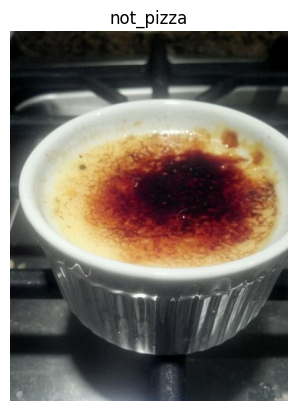

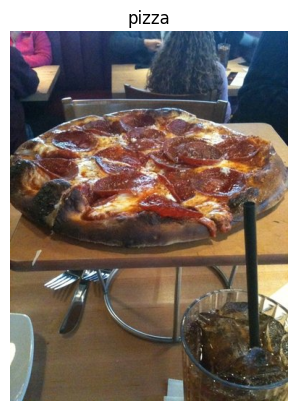

In [111]:
# Randomly selecting two pictures and displying them
sample = df.sample(2, random_state = 130)
for _, row in sample.iterrows():
    img = Image.open(row["filepath"])
    plt.imshow(img)
    plt.title(row["label"])
    plt.axis("off")
    plt.show()

In [112]:
# Sample the data using stratified sampling to keep the train and test datasets balanced
X = df['filepath']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify = y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [113]:
# This function to load image data in RGB format and resizing it to a fixed size

def load_and_resize(image_paths, size = (64, 64)):
    data = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")   # ensure 3 channels
        img = img.resize(size)                  # resize to 64x64
        data.append(np.array(img))
    return np.array(data)




num_px = 64
train_set_x = load_and_resize(X_train, size=(num_px, num_px))
test_set_x = load_and_resize(X_test, size=(num_px, num_px))

# Encode labels 
train_set_y = np.array(y_train.map(lambda lbl: 1 if lbl=="pizza" else 0))
test_set_y = np.array(y_test.map(lambda lbl: 1 if lbl=="pizza" else 0))


# Print shapes
print("Number of training examples: m_train =", train_set_x.shape[0])
print("Number of testing examples: m_test =", test_set_x.shape[0])
print("Each image is of size:", (num_px, num_px, 3))
print("train_set_x shape:", train_set_x.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x shape:", test_set_x.shape)
print("test_set_y shape:", test_set_y.shape)

Number of training examples: m_train = 1572
Number of testing examples: m_test = 394
Each image is of size: (64, 64, 3)
train_set_x shape: (1572, 64, 64, 3)
train_set_y shape: (1572,)
test_set_x shape: (394, 64, 64, 3)
test_set_y shape: (394,)


In [114]:
# X reshaping and standardizing
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T

train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

# Y reshaping to match (1, m)
train_set_y = train_set_y.reshape(1, -1)
test_set_y = test_set_y.reshape(1, -1)


# Print new shapes
print("train_set_x shape:", train_set_x.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x shape:", test_set_x.shape)
print("test_set_y shape:", test_set_y.shape)

train_set_x shape: (12288, 1572)
train_set_y shape: (1, 1572)
test_set_x shape: (12288, 394)
test_set_y shape: (1, 394)


(-0.5, 659.5, 413.5, -0.5)

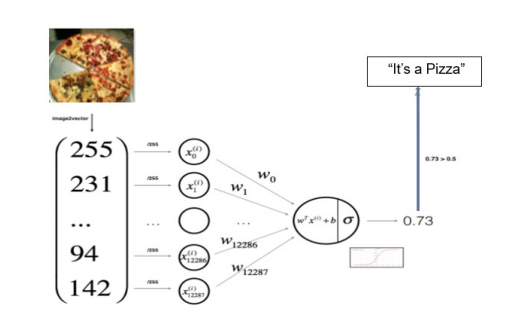

In [115]:
img = Image.open('General Architecture of the learning algorithm.jpg')
plt.imshow(img)
plt.axis("off")


In [116]:
class NeuralNetworkLogistic:
    def __init__(self, learning_rate, 
                 tolerance=1e-6, 
                 max_iter=10000, 
                 print_cost=False):
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.print_cost = print_cost
        self.w = None
        self.b = None
        self.costs = []

    def fit(self, X, Y):
        """
        Train the logistic regression model.
        X -- training set, numpy array of shape (n_features, m_samples)
        Y -- training labels, numpy array of shape (1, m_samples)
        """
        n_features, m = X.shape

        # Initialize parameters
        self.w = np.zeros((n_features, 1))
        self.b = 0.

        prev_cost = float('inf')

        for i in range(self.max_iter):
            # Forward propagation
            z = np.dot(self.w.T, X) + self.b
            A = 1 / (1 + np.exp(-z))
            epsilon = 1e-15
            cost = -(np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))) / m

            # Backward propagation
            dw = np.dot(X, (A - Y).T) / m
            db = np.sum(A - Y) / m

            # Update parameters
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db

            # Check convergence
            if abs(prev_cost - cost) < self.tolerance:
                if self.print_cost:
                    print(f"Converged at iteration {i}, cost={cost:.6f}")
                break

            prev_cost = cost

            # Record cost
            if i % 100 == 0:
                self.costs.append(cost)
                if self.print_cost:
                    print(f"Cost after {i}: {cost:.6f}")

        return self

    def predict_proba(self, X):
        """Return predicted probabilities."""
        z = np.dot(self.w.T, X) + self.b
        return 1 / (1 + np.exp(-z))

    def predict(self, X, threshold = 0.5):
        """Return predicted class labels (0 or 1)."""
        A = self.predict_proba(X)
        return (A > threshold).astype(int)
    
    # --- Metrics ---
    def confusion_matrix(self, X, Y, threshold=0.5):
        Y_pred = self.predict(X, threshold).flatten()
        Y_true = Y.flatten()

        TP = np.sum((Y_true == 1) & (Y_pred == 1))
        TN = np.sum((Y_true == 0) & (Y_pred == 0))
        FP = np.sum((Y_true == 0) & (Y_pred == 1))
        FN = np.sum((Y_true == 1) & (Y_pred == 0))

        # MultiIndex for columns
        columns = pd.MultiIndex.from_product(
            [["Predicted"], ["0", "1"]]
        )
        # MultiIndex for rows
        index = pd.MultiIndex.from_product(
            [["Actual"], ["0", "1"]]
        )

        return pd.DataFrame(
            [[TN, FP], [FN, TP]],
            index=index,
            columns=columns
        )

    def accuracy(self, X, Y, threshold=0.5):
        Y_pred = self.predict(X, threshold).flatten()
        Y_true = Y.flatten()
        return np.mean(Y_pred == Y_true)

    def precision(self, X, Y, threshold=0.5):
        Y_pred = self.predict(X, threshold).flatten()
        Y_true = Y.flatten()
        TP = np.sum((Y_true == 1) & (Y_pred == 1))
        FP = np.sum((Y_true == 0) & (Y_pred == 1))
        return TP / (TP + FP + 1e-15)

    def recall(self, X, Y, threshold=0.5):
        Y_pred = self.predict(X, threshold).flatten()
        Y_true = Y.flatten()
        TP = np.sum((Y_true == 1) & (Y_pred == 1))
        FN = np.sum((Y_true == 1) & (Y_pred == 0))
        return TP / (TP + FN + 1e-15)

    def f1(self, X, Y, threshold=0.5):
        prec = self.precision(X, Y, threshold)
        rec = self.recall(X, Y, threshold)
        return 2 * (prec * rec) / (prec + rec + 1e-15)

In [117]:
model = NeuralNetworkLogistic(learning_rate = 0.01)


In [118]:
model.fit(train_set_x, train_set_y)

In [119]:
Y_pred_train = model.predict(train_set_x)
Y_pred_test = model.predict(test_set_x)

In [120]:
model.confusion_matrix(test_set_x, test_set_y)

Predicted     
                 0    1
Actual 0       127   70
       1        69  128

In [88]:
model.accuracy(test_set_x, test_set_y)

0.6472081218274112

In [89]:
model.precision(test_set_x, test_set_y)

0.6464646464646465

In [90]:
model.recall(test_set_x, test_set_y)

0.649746192893401

In [91]:
model.f1(test_set_x, test_set_y)

0.6481012658227844

# Logistic Regression with sklearn

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [126]:
def load_prepare_data_for_sklearn(df, image_size=(64, 64), test_size=0.2):
    """
    Load pizza/not-pizza images and prepare them for scikit-learn.

    Arguments:
    df -- pandas DataFrame with columns 'filepath' and 'label'
    image_size -- tuple, the size to resize images (width, height)
    test_size -- fraction of data for test set
    random_state -- random seed for reproducibility

    Returns:
    X_train, X_test, y_train, y_test -- ready-to-use arrays for sklearn
    """
    # Separate file paths and labels
    X_paths = df['filepath'].values
    y_labels = df['label'].map(lambda x: 1 if x == "pizza" else 0).values  # encode labels

    # Load and resize images
    X_data = []
    for path in X_paths:
        img = Image.open(path).convert("RGB")          # ensure 3 channels
        img = img.resize(image_size)                   # resize
        X_data.append(np.array(img))
    
    X_data = np.array(X_data)                         # shape: (n_samples, width, height, 3)

    # Flatten and normalize for sklearn
    n_samples = X_data.shape[0]
    X_flat = X_data.reshape(n_samples, -1) / 255.0   # shape: (n_samples, width*height*3)

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat, y_labels, test_size=test_size, stratify=y_labels, random_state=42
    )

    return X_train, X_test, y_train, y_test


In [129]:
X_train_skl, X_test_skl, y_train_skl, y_test_skl = load_prepare_data_for_sklearn(df, image_size=(64, 64), test_size=0.2)

In [130]:
print(f"X_train shape: {X_train_skl.shape}")
print(f"X_test shape: {X_test_skl.shape}")
print(f"y_train shape: {y_train_skl.shape}")
print(f"y_test shape: {y_test_skl.shape}")

X_train shape: (1572, 12288)
X_test shape: (394, 12288)
y_train shape: (1572,)
y_test shape: (394,)


In [131]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(X_train_skl, y_train_skl)
Y_pred = clf.predict(X_test_skl)

In [132]:
# Accuracy
print("Sklearn Logistic Regression Accuracy:", accuracy_score(y_test_skl, Y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_skl, Y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
print("\nConfusion Matrix:")
print(cm_df)

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(y_test_skl, Y_pred))


Sklearn Logistic Regression Accuracy: 0.6269035532994924

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          135           62
Actual 1           85          112

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       197
           1       0.64      0.57      0.60       197

    accuracy                           0.63       394
   macro avg       0.63      0.63      0.63       394
weighted avg       0.63      0.63      0.63       394

